In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.optimus5 import load_saved_predictor

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

## Download Optimus 5' UTR model 
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/retrained_main_MRL_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/main_MRL_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/retrained_evolution_model.hdf5
#!wget https://github.com/pjsample/human_5utr_modeling/raw/master/modeling/saved_models/evolution_model.hdf5


In [3]:

def get_punish_start_tg() :
    
    def punish(pwm) :

        start_tg_score = pwm[..., 0, 3, 0] * pwm[..., 1, 2, 0]
        
        return start_tg_score
    
    return punish

def get_punish_atg(pwm_start, pwm_end) :
    
    def punish(pwm) :

        atg_score = K.sum(pwm[..., pwm_start:pwm_end-2, 0, 0] * pwm[..., pwm_start+1:pwm_end-1, 3, 0] * pwm[..., pwm_start+2:pwm_end, 2, 0], axis=-1)
        
        return atg_score
    
    return punish

#Define target isoform loss function
def get_earthmover_loss(pwm_start=0, pwm_end=50, pwm_target_bits=1.8, pwm_entropy_weight=0.0, punish_start_tg=0.0, punish_atg=0.0) :
    
    entropy_mse = get_margin_entropy(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    punish_start_tg_func = get_punish_start_tg()
    punish_atg_func = get_punish_atg(pwm_start=pwm_start, pwm_end=pwm_end)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_start_tg * K.mean(punish_start_tg_func(sampled_pwm), axis=0)
        seq_loss += punish_atg * K.mean(punish_atg_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_start_tg * K.mean(punish_start_tg_func(sampled_pwm), axis=0)
        seq_loss += punish_atg * K.mean(punish_atg_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)

#Sequence optimization monitor during training
class StoreSequenceMonitor(Callback):
    def __init__(self, seqprop_model, sequence_encoder, run_dir="", run_prefix="", store_every1=5, store_every2=100, swap_iter=100, val_steps=1) :
        self.seqprop_model = seqprop_model
        self.val_steps = val_steps
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        self.edit_distance_samples = []
        self.store_every1 = store_every1
        self.store_every2 = store_every2
        self.store_every = store_every1
        self.swap_iter = swap_iter
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        #self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        sampled_pwm = self.seqprop_model.predict(x=None, steps=self.val_steps)[2]
        
        seqs = []
        for i in range(sampled_pwm.shape[1]) :
            for j in range(sampled_pwm.shape[0]) :
                seqs.append(self.sequence_encoder.decode(sampled_pwm[j, i, :, :, 0]))
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.val_steps) + "_steps.txt", "w") as f:#"a+") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_batch_end(self, batch, logs={}) :
        
        if batch > self.swap_iter :
            self.store_every = self.store_every2
        
        if batch % self.store_every == 0 :
            seqs = self._sample_sequences()
            self._store_sequences(seqs, batch)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(run_prefix, sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode=eval_mode)
        _, valid_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_samples, eval_mode='sample')
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        measure_func = lambda pred_outs: np.expand_dims(np.mean(np.expand_dims(pred_outs[0][..., [0]], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0][..., [0]], axis=(0, -1)), axis=-1)
        
        valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Activity', plot_pwm_start=0, plot_pwm_end=50, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        #Standard sequence decoder
        acgt_encoder = IdentityEncoder(50, {'A':0, 'C':1, 'G':2, 'T':3})
        
        #Build callback for printing intermediate sequences
        store_seq_monitor = StoreSequenceMonitor(valid_generator, acgt_encoder, run_dir="./seqprop_samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            train_history,
            valid_history,
            store_seq_monitor
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = 'predictors'
model_name = 'retrained_main_MRL_model.hdf5'
model_path = os.path.join(save_dir, model_name)


In [5]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Optimizing objective 0...
Epoch 1/1
20000/20000 [==============================] - 324s 16ms/step - loss: -11.2369


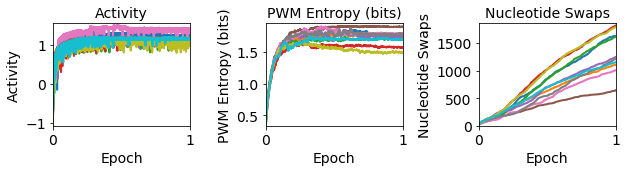

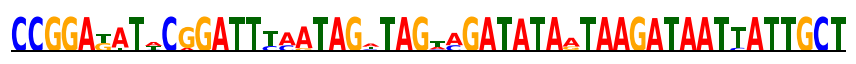

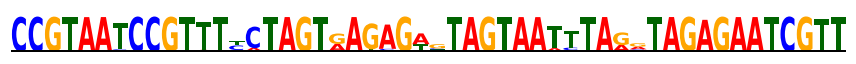

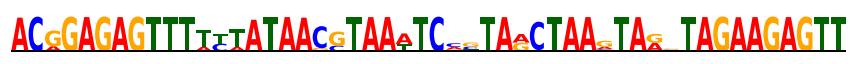

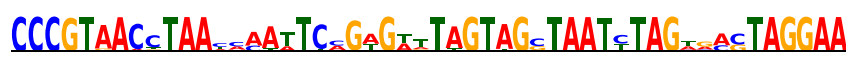

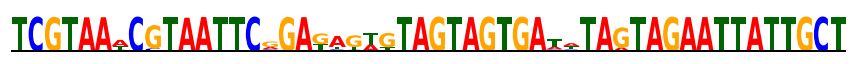

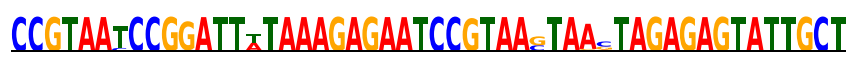

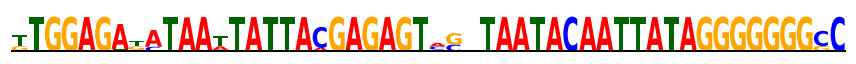

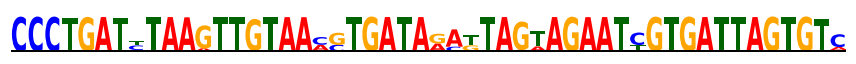

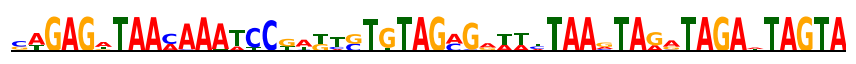

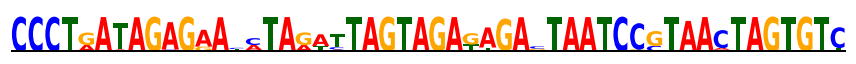

In [6]:

run_prefix = "seqprop_optimus5_retrained_st_20000_updates"

seq_template = 'N' * 50

rand_seed = 1177

#Run SeqProp Optimization

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Number of steps (grad updates) per epoch
steps_per_epoch = 20000
#Either 'gumbel' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = True
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 10

sequence_templates = [
    seq_template
]

losses, val_losses = zip(*[
    get_earthmover_loss(pwm_end=50, punish_start_tg=1.0, punish_atg=1.0)
])

transforms = [
    None
]

seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(run_prefix, sequence_templates, losses, val_losses, transforms, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]


In [ ]:
# Sequences saved in seqprop_samples/seqprop_optimus5_retrained_st_20000_updates